# Using the Monotonic Mask constraint in scarlet

This notebook is designed to demonstrate the use of the monotonic mask constraint in scarlet.

In [1]:
# Import Packages and setup
import os
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)

import numpy as np
import scarlet
import scarlet.display
from scarlet.display import AsinhMapping
from scarlet.operator import prox_monotonic_mask
from scarlet.operators_pybind11 import get_valid_monotonic_pixels, linear_interpolate_invalid_pixels

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin="lower")

# Load the data and initialize the scarlet model and observation classes

loading data from'/Users/fred3m/data/hsc_deep/blend_10.npz'


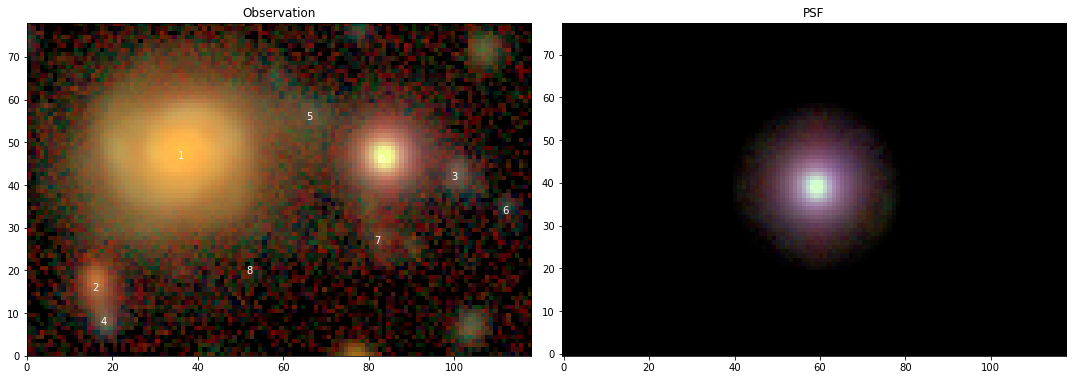

In [2]:
# Load the exposure data
filters = "grizy"
idx = 10
datapath = "/Users/fred3m/data/hsc_deep"
filename = "blend_{0}.npz".format(idx)
print("loading data from'{0}'".format(os.path.join(datapath, filename)))
data = np.load(os.path.join(datapath, filename))
images = data["image"]
mask = data["mask"]
variance = data["variance"]
weights = 1/variance
psf = scarlet.ImagePSF(data["psf"])
centers = data["peaks"]

# Initialize the scarlet model
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))
model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)
# Initialize the observation
observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)
# Display the observation
stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True, figsize=(15,9))
plt.show()

# Apply the monotonic_mask prox to all of the peaks in the image

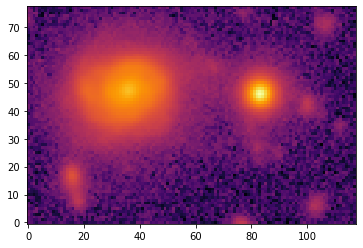

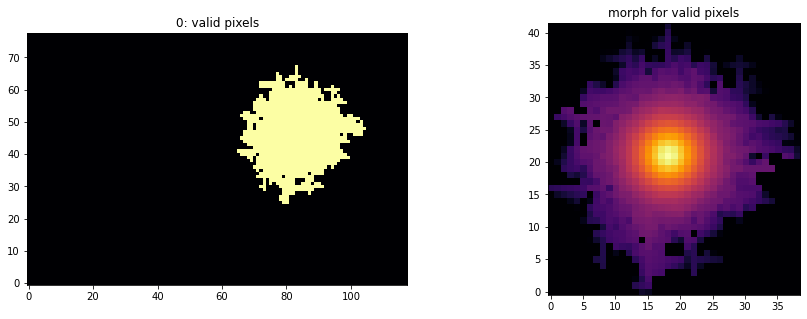

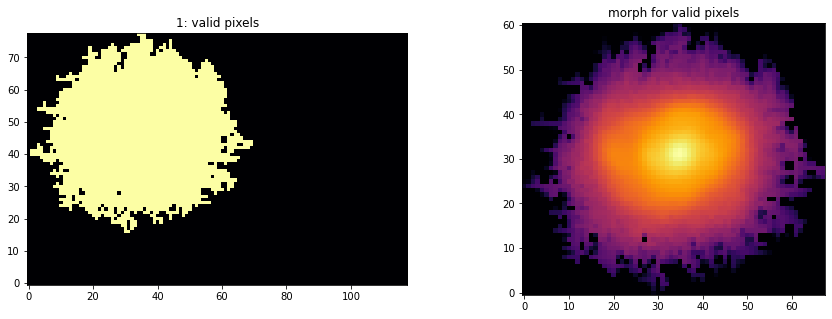

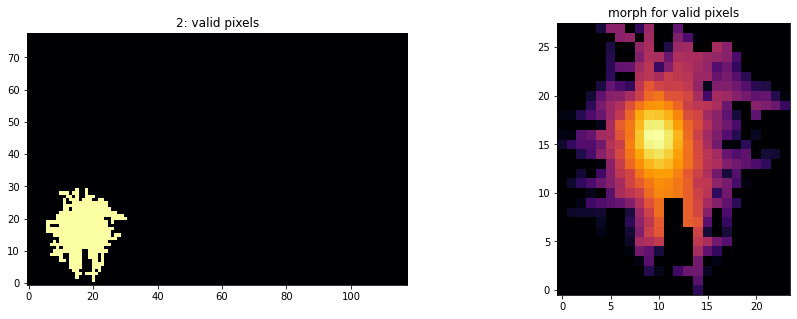

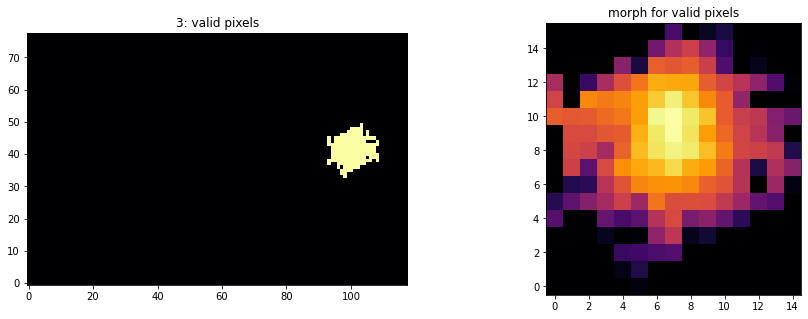

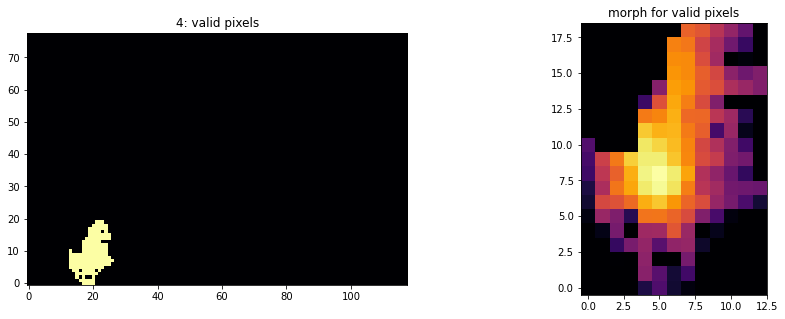

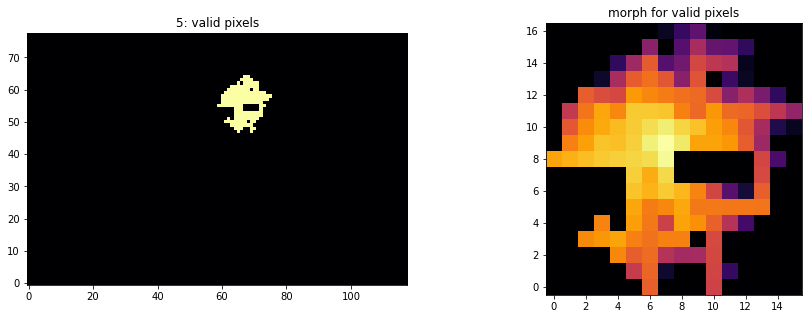

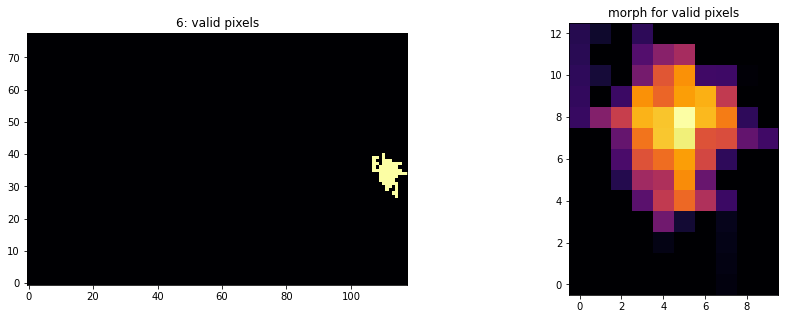

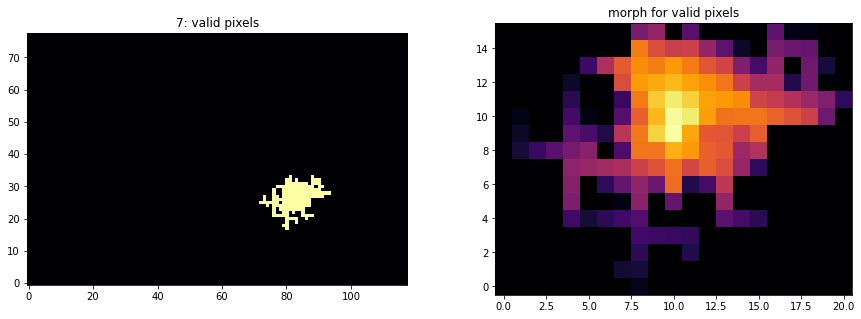

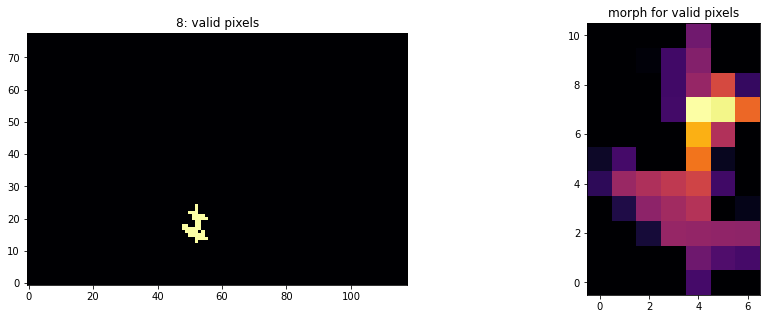

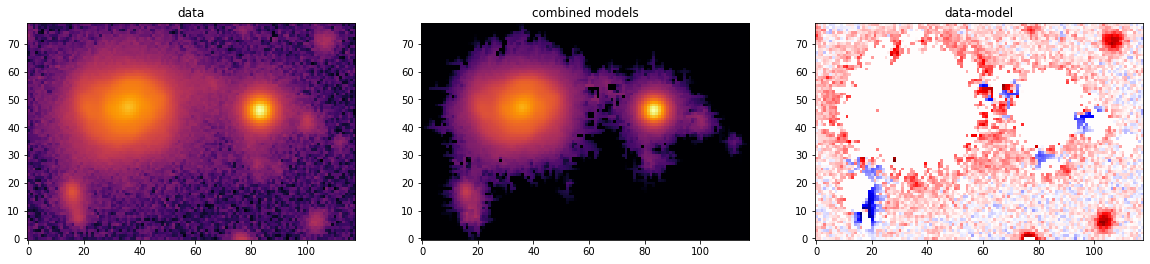

In [7]:
# Create a detection image
img = np.sum(images, axis=0)
plt.imshow(np.arcsinh(10*img)/10)
plt.show()

# Keep track of the aggregate model
model = np.zeros(img.shape, dtype=float)
for k, center in enumerate(centers):
    valid, _model, bounds = prox_monotonic_mask(img, 0, center, center_radius=2, variance=0, max_iter=3)
    
    fig = plt.figure(figsize=(15, 5))
    ax = [fig.add_subplot(1, 2, n+1) for n in range(2)]
    ax[0].imshow(valid, origin="lower")
    ax[0].set_title(f"{k}: valid pixels")
    ax[1].imshow(np.arcsinh(10*_model[bounds[0]:bounds[1], bounds[2]:bounds[3]])/10)
    ax[1].set_title("morph for valid pixels")
    plt.show()
    
    model += _model

# Display the full model and residuals
fig = plt.figure(figsize=(20, 7))
ax = [fig.add_subplot(1, 3, n+1) for n in range(3)]
ax[0].imshow(np.arcsinh(10*img)/10)
ax[0].set_title("data")
ax[1].imshow(np.arcsinh(10*model)/10)
ax[1].set_title("combined models")
residual = img - model
for n in range(4):
    residual[np.unravel_index(np.argmax(residual), residual.shape)] = 0
vmax = np.max(residual)
ax[2].imshow(residual, cmap="seismic", vmin=-vmax, vmax=vmax)
ax[2].set_title("data-model")
plt.show()